# Model pipeline draft

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, Sequential, Input, Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.data.experimental import cardinality
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path0 = r'C:\Users\pitip\code\ClaireLeroux44\ArtRecognition'
n_artist = 3

Steps:
- load images from dataset (after folder prep) : image from dataset
- load VGG16
- change VGG16 last layer (add N artist id)
- train VGG16 on dataset
- predict artist on test set + accuracy

In [3]:
def VGG16_model(ndense_1=100):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False

    model_layers = [base_model, layers.Flatten(), 
                  layers.Dense(ndense_1, activation='relu')]
    model = models.Sequential(layers = model_layers)
    return model

model1 = VGG16_model(ndense_1=100)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
Total params: 17,223,588
Trainable params: 2,508,900
Non-trainable params: 14,714,688
_________________________________________________________________


In [4]:
train_dir = os.path.join(path0, 'raw_data', 'test_VGG16', 'Train')
test_dir = os.path.join(path0, 'raw_data', 'test_VGG16', 'Test')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, label_mode='categorical')
test_dataset = image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, label_mode='categorical')

Found 15 files belonging to 3 classes.
Found 9 files belonging to 3 classes.


In [5]:
class_names = train_dataset.class_names
class_names

['class_1', 'class_2', 'class_3']

In [6]:
train_batches = cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_train_dataset = train_dataset.skip(train_batches // 5)

In [7]:
train_train_dataset = train_train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
print('Number of validation batches: %d' % cardinality(validation_dataset))
print('Number of test batches: %d' % cardinality(test_dataset))

Number of validation batches: 0
Number of test batches: 1


In [9]:
for image_batch, labels_batch in test_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)

(9, 224, 224, 3)
(9, 3)


In [10]:
data_augmentation = Sequential([layers.experimental.preprocessing.RandomFlip('horizontal'),
                                layers.experimental.preprocessing.RandomRotation(0.1),
                                layers.experimental.preprocessing.RandomContrast(0.1),
                                layers.experimental.preprocessing.RandomZoom(height_factor=0.2),
                                layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

In [11]:
#image_batch, label_batch = next(iter(train_dataset))
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

In [12]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = model1(x)
prediction_layer = layers.Dense(n_artist, activation='softmax')
outputs = prediction_layer(x)
model = Model(inputs, outputs)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [14]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100)               17223588  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 17,223,891
Trainable params: 2,509,203
Non-trainable params: 14,714,688
__________________________________

In [17]:
history = model.fit(train_train_dataset, epochs=10, validation_data=test_dataset, batch_size=32, 
                    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.4811 - accuracy: 0.9333 - val_loss: 20.9028 - val_accuracy: 0.5556
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.7507e-04 - accuracy: 1.0000 - val_loss: 21.1860 - val_accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0767 - accuracy: 0.9333 - val_loss: 21.4802 - val_accuracy: 0.6667


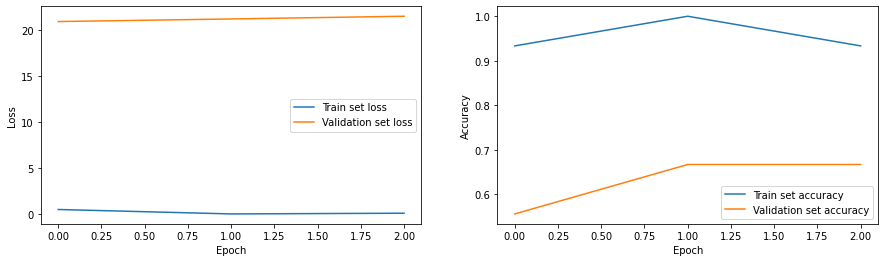

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(history.history['loss'], label='Train set loss')
ax[0].plot(history.history['val_loss'], label='Validation set loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(history.history['accuracy'], label='Train set accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation set accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy');

In [19]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 3ms/step - loss: 20.9028 - accuracy: 0.5556
Test accuracy : 0.5555555820465088
